# Week 3 Project

### In this notebook, we'll develop a CNN model to solve the Histopathologic Cancer challenge, on Kaggle

In [1]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

2024-06-05 16:20:07.435572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 16:20:07.435751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 16:20:07.633767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset

#### Let's start by exploring the given files

In [5]:
BASE_PATH = '../input/histopathologic-cancer-detection'
os.listdir(BASE_PATH)

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

## Data dimensions

#### Let's now inspect the number of training and test samples provided

### Train

In [6]:
BASE_TRAIN_PATH = os.path.join(BASE_PATH, 'train')
N_TRAIN = len(os.listdir(BASE_TRAIN_PATH))
print(f'Train set has {N_TRAIN} imgaes.')

Train set has 220025 imgaes.


### Test

In [66]:
BASE_TEST_PATH = os.path.join(BASE_PATH, 'test')
N_TEST = len(os.listdir(BASE_TEST_PATH))
print(f'Test set has {N_TEST} imgaes.')

Test set has 57458 imgaes.


### Loading labels dataset into DataFrame

In [9]:
labels_df = pd.read_csv(f'{BASE_PATH}/train_labels.csv')

In [10]:
nrows, ncols = labels_df.shape
print(f'Dataframe has {nrows} rows and {ncols} columns.')

Dataframe has 220025 rows and 2 columns.


## Data Visualization

#### We'll use a helper method to support us on the visualization task

In [11]:
def draw_category_images(df, figure_cols=4, col_name = 'label', IMAGE_PATH=BASE_TRAIN_PATH):
    
    """
    Helper method that displays a random sample of the images
    """
    
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=f'{IMAGE_PATH}/{sample.iloc[j]["id"]}.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

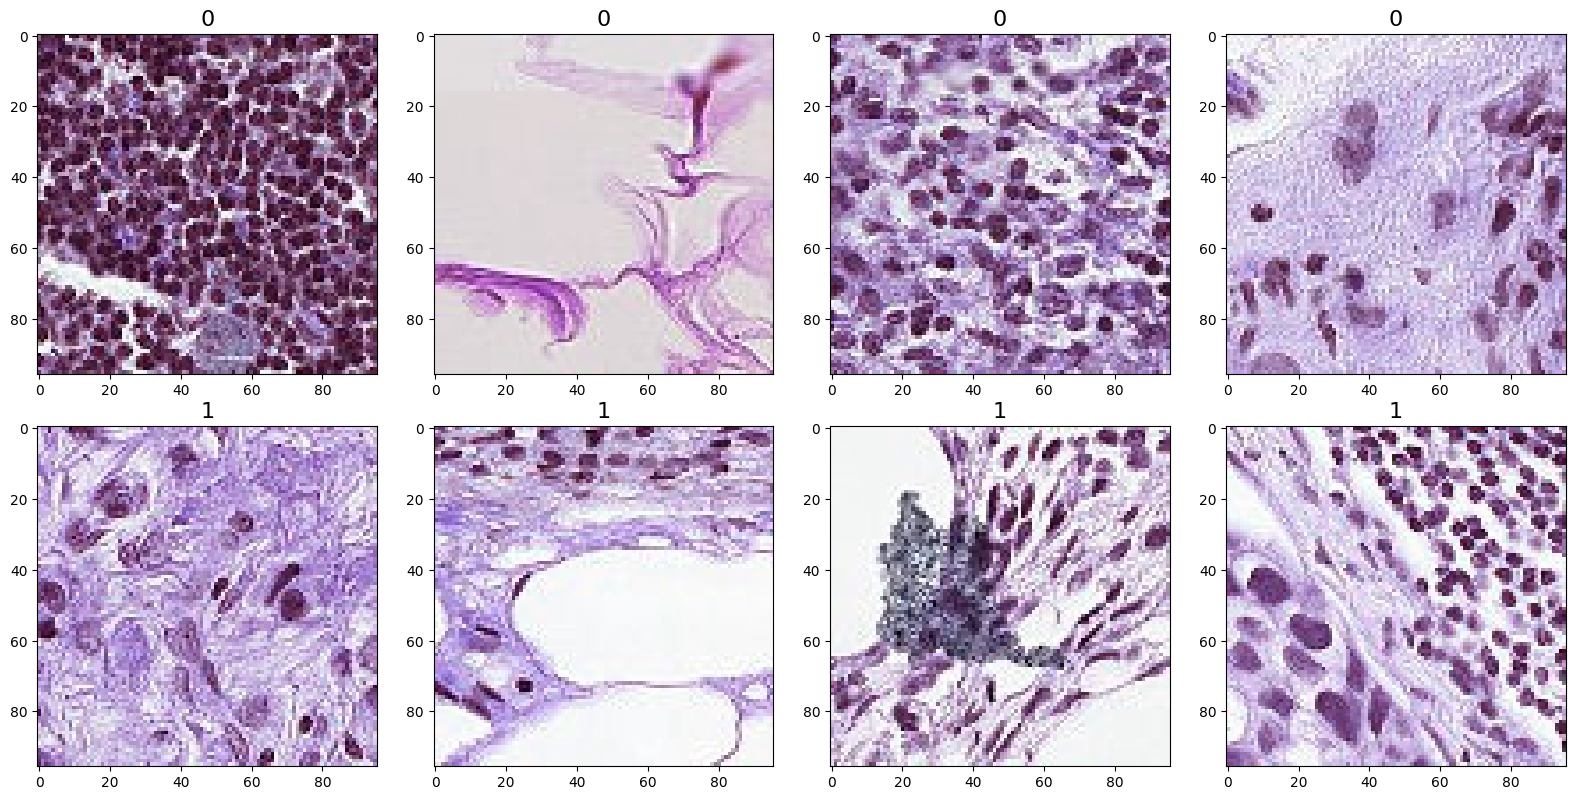

In [12]:
draw_category_images(labels_df)

In [13]:
labels_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

### Parameters definition

In [14]:
IMAGE_SIZE = 48
IMAGE_CHANNELS = 3
DATA_DIR = 'dataset'
SAMPLE_SIZE = 20000

## Train Dataset

**As we observed, the data set is not balanced for type 0 (*no tumor tissue*) and type 1 (*has tumor tissue*). Let's define a method that receives the dataset and returns an df with a balanced sample of each category, based on a given sample size**

In [15]:
def get_balanced_sample(df, SAMPLE_SIZE, col='label'):
    '''
    This method takes a dataframe, sample size and col, and returns
    a shuffled DF with balanced number of categories
    '''
    sample_types = dict()
    
    for cat in df[col].unique():
        sample_types.update({
            str(cat): df[df[col] == cat].sample(SAMPLE_SIZE)
        })
        
    balanced_df = shuffle(
        pd.concat(
            sample_types.values(),axis=0) \
            .reset_index(drop=True))
    balanced_df.set_index('id', inplace=True)
    
    return balanced_df

In [16]:
balanced_df = get_balanced_sample(labels_df, SAMPLE_SIZE)
balanced_df['label'].value_counts()

label
0    20000
1    20000
Name: count, dtype: int64

In [17]:
y = balanced_df['label']

train_df, val_df = train_test_split(balanced_df, test_size=0.30, random_state=101, stratify=y)

## Let's now create the directory structure used by Keras's ImageDataGenerator

In [18]:
img_train_path = os.path.join(DATA_DIR, 'train')
img_val_path = os.path.join(DATA_DIR, 'val')
no_tumor_train = os.path.join(img_train_path, 'no_tumor')
has_tumor_train = os.path.join(img_train_path, 'has_tumor')
no_tumor_val = os.path.join(img_val_path, 'no_tumor')
has_tumor_val = os.path.join(img_val_path, 'has_tumor')

In [19]:
def create_dir(*paths):
    '''
    Method that receives one or more paths as input and creates folder structures
    based on those
    '''
    for path in paths:
        if not os.path.exists(path):
            os.mkdir(path)
        print(f'Folder {path} created.')

In [20]:
create_dir(
    DATA_DIR,
    img_train_path,
    img_val_path,
    no_tumor_train,
    has_tumor_train,
    no_tumor_val,
    has_tumor_val
)

Folder dataset created.
Folder dataset/train created.
Folder dataset/val created.
Folder dataset/train/no_tumor created.
Folder dataset/train/has_tumor created.
Folder dataset/val/no_tumor created.
Folder dataset/val/has_tumor created.


## Now that we have created the folders, let's define a function to transfer the images

In [22]:
def display_dataset_contents(*paths):
    for path in paths:
        print(f'Nº of images on {path}')
        print(len(os.listdir(path)))
        print('-----------------------')


def transfer_images(base_df, train_path, val_path, *model_dfs):
    '''
    Helper method to tranfer images to their respective train/val directories
    '''
    paths = list()
    for df in model_dfs:
        dest_path = img_val_path if df.shape[0] < SAMPLE_SIZE*.7 else img_train_path
        for img_id in df.index:
            # add tif extension to id to get image name
            image = f'{img_id}.tif'
            label = base_df.loc[img_id,'label']
            sub_dir = "no_tumor" if label == 0 else "has_tumor"
            src = os.path.join(BASE_TRAIN_PATH, image)
            dst = os.path.join(dest_path, sub_dir, image)
            shutil.copyfile(src, dst)
            

In [26]:
transfer_images(
    balanced_df,
    img_train_path,
    img_val_path,
    train_df,
    val_df
)

In [27]:
display_dataset_contents(
    os.path.join(img_train_path, 'has_tumor'),
    os.path.join(img_train_path, 'no_tumor'),
    os.path.join(img_val_path, 'has_tumor'),
    os.path.join(img_val_path, 'has_tumor')
)  

Nº of images on dataset/train/has_tumor
14000
-----------------------
Nº of images on dataset/train/no_tumor
14000
-----------------------
Nº of images on dataset/val/has_tumor
6000
-----------------------
Nº of images on dataset/val/has_tumor
6000
-----------------------


## Model Development

### Generator

#### We'll use Kera's genrator with a mini batch size of 128 and rescaling

In [28]:
train_batch_size = 128
val_batch_size = 128


train_steps = int(np.ceil(len(train_df) / train_batch_size))
val_steps = int(np.ceil(len(val_df) / val_batch_size))

In [29]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(img_train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')


val_gen = datagen.flow_from_directory(img_val_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary', # Has / No Tumor
                                        shuffle=False)

Found 28000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


## Model Architecture

We'll use a tipical Architecure with 3 Convolutional Layers, each using:

- batching normalization to support/speed up the gradients/optmization calulation
- relu activation functions for non-linearity
- Dropout for regularization/ Avoid Overfitting 

The final Layer will be a fully conected dense layer also using batch normalization and Droput but now having Sigmoid as activation, once this is a binary classification task

In [30]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 420,609 (1.60 MB)

 Trainable params: 419,265 (1.60 MB)

 Non-trainable params: 1,344 (5.25 KB)

### Compile the Model

#### We'll now compile the model using ADAM as the optimization algorithm, binary crossentropy for our loss and we'll optmize for accuracy

In [31]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

## Model History

We'll use pass an adaptative learning rate as a callback, (Reduce on Plateau) for faster convergence and 

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=[reduce_lr])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 165s 723ms/step - accuracy: 0.6862 - loss: 0.6262 - val_accuracy: 0.7021 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7553 - val_loss: 0.5581 - learning_rate: 1.0000e-04
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 158s 714ms/step - accuracy: 0.7493 - loss: 0.5310 - val_accuracy: 0.8298 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8723 - val_loss: 0.3328 - learning_rate: 1.0000e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 157s 714ms/step - accuracy: 0.7703 - loss: 0.4965 - val_accuracy: 0.8723 - val_loss: 0.4029 - learning_rate: 1.0000e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9255 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 158s 716ms/step - accuracy: 0.7806 - loss: 0.4781 - val_accuracy: 0.8298 - val_loss: 0.4422 - learning_rate: 1.0000e-04
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━

## Training History Plot

#### Let's now define a method to helps visualize the evolution of the training over the epochs

<Figure size 640x480 with 0 Axes>

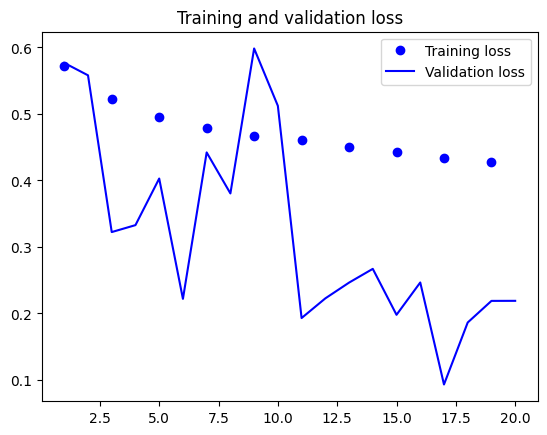

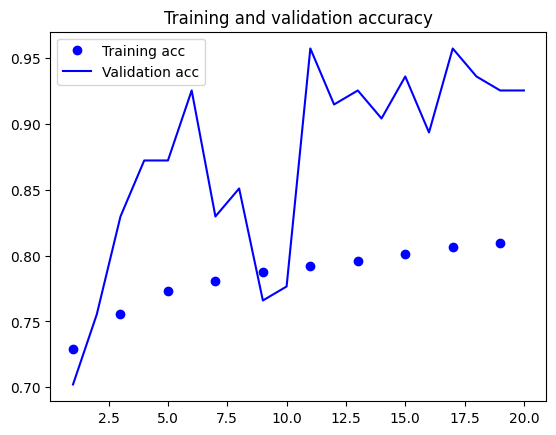

<Figure size 640x480 with 0 Axes>

In [54]:
def plot_model_metrics(acc, val_acc, loss, val_loss):
    '''
    Helper method that receives lists of accuraccy and loss for both training and validation sets
    and plots trends over epochs
    '''
    epochs = range(1, 21)

    plt.plot(x=epochs, y=loss, 'bo', label='Training loss')
    plt.plot(x=epochs, y=val_loss, 'b', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.figure()

    plt.plot(x=epochs, y=acc, 'bo', label='Training accuracy')
    plt.plot(x=epochs, y=val_acc, 'b', label='Validation accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.figure()

In [ ]:
acc = [i if i > 0 else None for i in history.history['accuracy']]
val_acc = [i for i in history.history['val_accuracy']]
loss = [i if i > 0 else None for i in history.history['loss']]
val_loss = [i for i in history.history['val_loss']]

plot_model_metrics(acc, val_acc, loss, val_loss)

## Test data

#### Now that we've built our model, let's prepare the test dataset, that would be submited to the challenge

In [ ]:
test_path = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [65]:
# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [68]:
test_list = os.listdir(BASE_TEST_PATH)

for image in test_list:
    fname = image
    src = os.path.join(BASE_TEST_PATH, fname)
    dst = os.path.join(test_images, fname)
    shutil.copyfile(src, dst)

In [72]:
len(os.listdir('test_dir/test_images'))

57458

## Test Generator

In [73]:
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [75]:
predictions = model.predict(test_gen, steps=len(os.listdir('test_dir/test_images')), verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 347s 6ms/step


In [95]:
predictions.flatten()

array([0.06896807, 0.13803396, 0.08014479, ..., 0.9675036 , 0.03229782,
       0.7182445 ], dtype=float32)

In [83]:
files = test_gen.filenames
files[0]

'test_images/00006537328c33e284c973d7b39d340809f7271b.tif'

### We'll deifne a helper method to extract the id's form the file paths

In [90]:
def get_id_from_path(file_name):
    return file_name.split('/')[1].split('.')[0]

In [91]:
ids = [get_id_from_path(file) for file in files]
ids[0:5]

['00006537328c33e284c973d7b39d340809f7271b',
 '0000ec92553fda4ce39889f9226ace43cae3364e',
 '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
 '000253dfaa0be9d0d100283b22284ab2f6b643f6',
 '000270442cc15af719583a8172c87cd2bd9c7746']

In [96]:
submission = pd.DataFrame({'id':ids, 
                           'label':predictions.flatten(), 
                          }).set_index('id')

In [98]:
submission.to_csv('submission.csv', columns=['label']) 

In [100]:
shutil.rmtree('dataset')